# Home work 5: Basic Artificial Neural Networks

На семинаре вы написали нейронную сеть. Настало время ее использовать!  В этом ноутбуке вы создадите нейронную сеть и методом градиентного спуска обучите ее распознавать цифры.

В этой домашней работе вам потребуются три ноутбука: **modules.ipynb**, **main.ipynb**, с помощью которого вы сможете отладить реализацию методов в modules.ipynb, и **nn.ipynb** (этот ноутбук). Сдать нужно все три ноутбука.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework (5 баллов)

Решите раздел backward в main.ipynb, убедитесь что все ячейки отрабатывают без ошибок и что относительная погрешность там же не превышает 1e-4 для каждого теста.

# Toy example

In [2]:
%run modules.ipynb
%load_ext autoreload
%autoreload 2

Оптимизация методом стохастического градиентного спуска уже написана за вас.

In [3]:
def sgd(x, dx, config):
    """        
        config:
            - learning_rate
    """
    
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            cur_x -=  config['learning_rate'] * cur_dx

Давайте еще раз протестируем наши модули на искуственно сгенерированной выборке.

В этом блоке вам не надо ничего реализовывать.

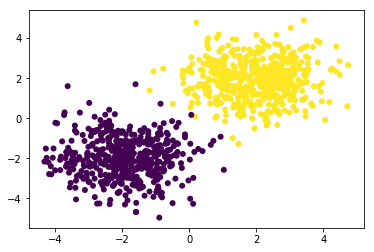

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Мы решаем задачу многоклассовой классификации с двумя классами. Истинный вектор для каждого объекта - это вектор из 0 и 1, в котором 1 стоит на том месте, какому классу принадлежит объект. Хочется чтобы сеть выдавала набор чисел, каждое из которых являлось бы степенью уверенности сети в принадлежности объекта соответствующему классу (так вектор (0.9, 0.1) означал бы что сеть считает, что объект скорее всего принадлежит нулевому классу, а не первому). Давайте зададим пару ограничений на уверенность:

1) Наша уверенность не может быть отрицательной. 

2) В сумме наша уверенность по всем объектам должна давать 1.

Набор чисел на которых выполнены эти два свойства называют распределением вероятностей.

Сеть может выдавать отрицательные числа, не говоря о том, что сумма предсказаний для объекта может быть больше единицы. Чтобы получить из произвольного набора чисел распределение вероятностей придумали функцию **SoftMax**. Её формула: $$output_i = \frac{e^{input_i}}{\sum_n e^{input_n}}.$$

Что он делает - это переводит входной вектор в вектор вероятностей (неотрицательных чисел в сумме дающих единицу).

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = MSECriterion()

# Попробуйте что-нибудь вроде этого:

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(Sigmoid())
# net.add(Linear(4, 2))
# net.add(SoftMax())


# net = Sequential()
# net.add(Linear(2, 4))
# net.add(Sigmoid())
# net.add(Linear(4, 2))
# net.add(Sigmoid())
# net.add(Linear(2, 2))
# net.add(SoftMax())# 

print(net)

Sequential: 
    Linear 2 -> 2
    SoftMax


In [6]:
optimizer_config = {'learning_rate' : 1e-2}
optimizer_state = {}

n_epoch = 20
batch_size = 128

In [7]:
# генератор минибатчей
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # после каждой эпохи мы заново перемешиваем объекты тренировочной выборки
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Давайте обучим модель.

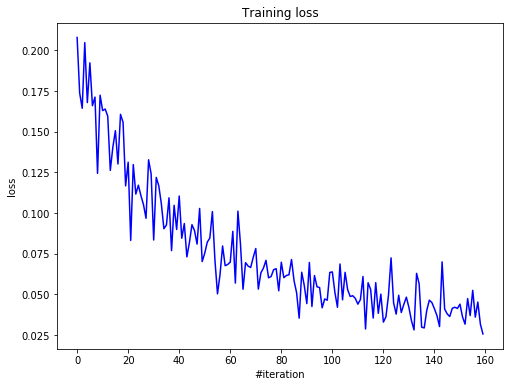

Current loss: 0.025711


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [9]:
net.forward(np.array([[ 1.62949297,  2.7099471 ]]))

array([[ 0.97645324,  0.02354676]])

# Digit classification (5 баллов)

Ваша задача - обучиться распознавать рукописные цифры из датасета MNIST.

In [10]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

def one_hot_encode(data, n_classes=10):
    n_objects = len(data)
    data_encoded = np.zeros((n_objects, n_classes))
    data_encoded[np.arange(n_objects), data.astype(int)] = 1
    return data_encoded

y = one_hot_encode(y)

In [11]:
tmp = np.hstack((X, y))
np.random.shuffle(tmp)
X = tmp[:, :-10]
y = tmp[:, -10:]
print(X.shape, y.shape)

(70000, 784) (70000, 10)


In [12]:
X_test = X[-1000:]
y_test = y[-1000:]
X = X[:-1000]
y = y[:-1000]

In [13]:
net = Sequential()

net.add(Linear(784, 64))
net.add(Sigmoid())
net.add(Linear(64, 16))
net.add(Sigmoid())
net.add(Linear(16, 10))
net.add(SoftMax())
    
print(net)

Sequential: 
    Linear 784 -> 64
    Sigmoid
    Linear 64 -> 16
    Sigmoid
    Linear 16 -> 10
    SoftMax


Поэкспериментируйте с разным количеством скрытых слоев, с разным размером слоев, попробуйте поменять функцию активации. По итогу напишите отчет о проведенных экспериментах который включате в себя описание того, что вы сделали, и то, какую точность по метрике mse вы смогли получить.

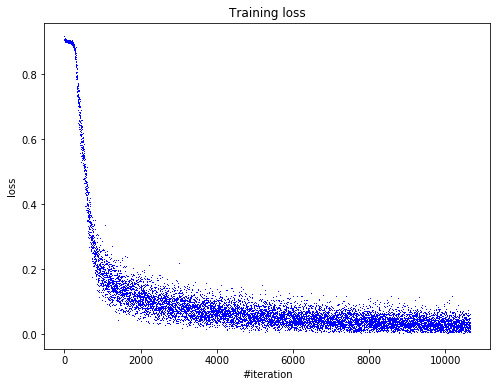

Current loss: 0.035250


In [14]:
loss_history = []

optimizer_config = {'learning_rate' : 1}
optimizer_state = {}

n_epoch = 200
batch_size = 100

criteron = MSECriterion()

f = True
while f:
    for i, (x_batch, y_batch) in enumerate(get_batches((X, y), batch_size)):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd(net.getParameters(),net.getGradParameters(), optimizer_config)      
        
        loss_history.append(loss)
        if i % 100 == 0:
            # Visualize
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("Training loss")
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b,')
            plt.show()

            print('Current loss: %f' % loss)
            if len(loss_history) > 1000 and sum(loss_history[-1000:]) / 1000 < 0.03:
                f = False
                break

In [15]:
def plot_gallery(images, h, w, n_row=3, n_col=6, cmap="gray"):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=cmap, interpolation='nearest')
        plt.title(str(i + 1), size=12)
        plt.xticks(())
        plt.yticks(())

Вот так выглядят веса нейронов первого слоя:

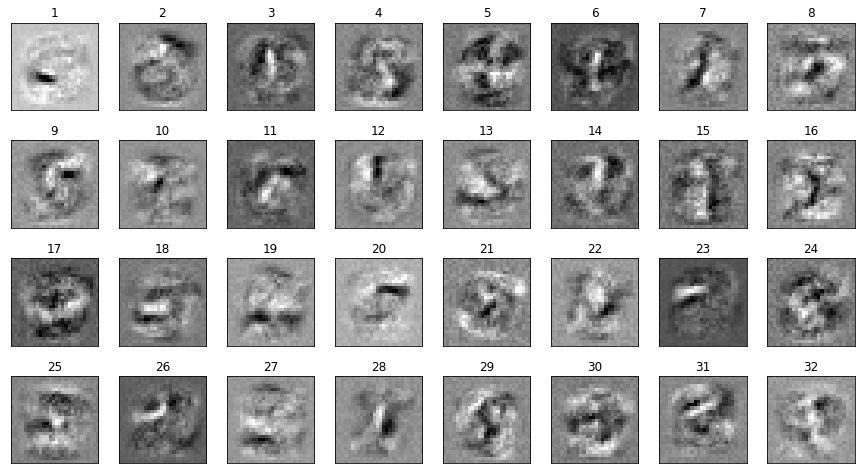

In [16]:
plot_gallery(net.modules[0].W, 28, 28, 4, 8)

А это второй:

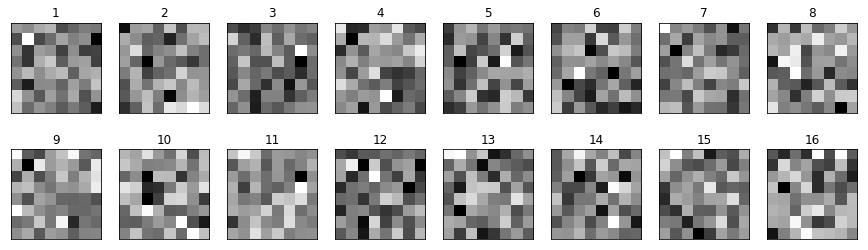

In [17]:
plot_gallery(net.modules[2].W, 8, 8, 2, 8)

In [18]:
from sklearn.metrics import accuracy_score

print("Accuracy on test data is {:.1f}%".format(
    accuracy_score(np.argmax(y_test, 1), np.argmax(net.forward(X_test), 1)) * 100
))

Accuracy on test data is 97.0%


# Отчет

1. Глубокие сети оказались плохой идеей
2. ReLU обучается чуть быстрее, но на последней стадии спуска (_loss_ < 0.1) сигмоида ведёт себя лучше.
3. Для этой сети оказался нужен большой *activation_rate*, что неожиданно.
4. Даже маленькие слои (64 > 16 > 10) привели к хорошему результату.
5. Первый слой даже улавливает какие-то закорючки, что очень хорошо для такой простой сети.